In [1]:
#import data manipulation and analysis libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
import xgboost
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#import regression libraries
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, Lasso, LassoLars
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [3]:
#Read the data file from csv into a DataFrame
df = pd.read_csv('Get Around Data for Case Study.csv')

In [4]:
#display the first 5 rows of data
df.head()

,driver_id,owner_id,driver_age,make,model,payment_type,completed_trips,vehicle_price,lead_time,trip_length,trip_revenue,young_driver_fee,insurance_fee,delivery_fee,other_revenue,gross_revenue,owner_earnings,net_revenue,first_or_returning_guest,first_or_returning_host
0,1555955,338656,24.0,Hyundai,Accent,Debit,3,7893,1.17,2.00,92,18,14,-,9,133,69,64,Repeat,Repeat
1,196066,1944996,42.0,Dodge,Grand Caravan,Credit,1,9738,52.63,8.69,450,-,-,20,79,549,385,163,First Time,Repeat
2,2717284,1661563,26.0,Toyota,Corolla,Credit,1,6758,0.05,2.00,70,-,11,-,7,88,53,35,First Time,Repeat
3,1916312,1661563,24.0,Toyota,Corolla,Debit,1,6758,0.14,9.04,284,85,43,40,203,654,402,252,First Time,Repeat
4,2158072,64977,33.0,Chevrolet,Suburban,Credit,3,40950,31.77,6.96,455,-,-,40,46,541,446,95,Repeat,Repeat


In [5]:
#The data and columns have lots of whitespace
#This is causing some numeric columns to be interpreted as strings instead of numbers
#These functions will strip the whitespace from around strings
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df = df.rename(columns=lambda x: x.strip())
df.head()

,driver_id,owner_id,driver_age,make,model,payment_type,completed_trips,vehicle_price,lead_time,trip_length,trip_revenue,young_driver_fee,insurance_fee,delivery_fee,other_revenue,gross_revenue,owner_earnings,net_revenue,first_or_returning_guest,first_or_returning_host
0,1555955,338656,24.0,Hyundai,Accent,Debit,3,7893,1.17,2.00,92,18,14,-,9,133,69,64,Repeat,Repeat
1,196066,1944996,42.0,Dodge,Grand Caravan,Credit,1,9738,52.63,8.69,450,-,-,20,79,549,385,163,First Time,Repeat
2,2717284,1661563,26.0,Toyota,Corolla,Credit,1,6758,0.05,2.00,70,-,11,-,7,88,53,35,First Time,Repeat
3,1916312,1661563,24.0,Toyota,Corolla,Debit,1,6758,0.14,9.04,284,85,43,40,203,654,402,252,First Time,Repeat
4,2158072,64977,33.0,Chevrolet,Suburban,Credit,3,40950,31.77,6.96,455,-,-,40,46,541,446,95,Repeat,Repeat


In [6]:
#The numeric columns with strings need to be converted to floats
#This cell defines the numeric and categorical features
#Then loops through numeric features and converts them to floats
numericColumns = ['driver_age','completed_trips','vehicle_price','lead_time','trip_length','trip_revenue','young_driver_fee','insurance_fee','delivery_fee','other_revenue','gross_revenue','owner_earnings','net_revenue']
categoricalColumns = ['payment_type','first_or_returning_guest','first_or_returning_host']
for c in numericColumns:
    df[c] = pd.to_numeric(df[c], errors='coerce',downcast='float')

In [7]:
#Show statistical description of each numeric feature
df.describe()

,driver_id,owner_id,driver_age,completed_trips,vehicle_price,lead_time,trip_length,trip_revenue,young_driver_fee,insurance_fee,delivery_fee,other_revenue,gross_revenue,owner_earnings,net_revenue
count,7.355500e+04,7.355500e+04,73546.000000,73555.000000,73555.000000,73555.000000,73555.000000,72819.000000,12293.000000,50973.000000,11559.000000,73439.000000,71899.000000,72733.000000,73144.000000
mean,4.082790e+06,2.584958e+06,33.257675,4.479600,16310.834961,5.582101,4.122981,172.356903,43.968681,36.211956,39.411713,39.307793,236.449524,156.171783,98.147079
std,2.219926e+06,1.988449e+06,9.425288,7.875206,13773.302734,14.337815,6.114041,143.716003,39.296471,44.077023,22.956507,79.261772,176.178131,138.542313,92.919617
min,4.850000e+02,1.555400e+04,20.000000,1.000000,100.000000,-0.020000,0.040000,10.000000,2.000000,2.000000,5.000000,0.000000,10.000000,1.000000,1.000000
25%,2.375330e+06,1.097455e+06,26.000000,1.000000,7597.000000,0.140000,1.770000,76.000000,20.000000,14.000000,20.000000,10.000000,111.000000,66.000000,41.000000
50%,3.897772e+06,2.098791e+06,31.000000,2.000000,12249.000000,0.810000,3.000000,135.000000,34.000000,24.000000,35.000000,17.000000,191.000000,117.000000,73.000000
75%,5.653818e+06,4.108501e+06,38.000000,4.000000,19491.000000,3.750000,4.880000,220.000000,54.000000,43.000000,50.000000,33.000000,309.000000,197.000000,122.000000
max,8.920084e+06,8.873825e+06,90.000000,144.000000,200800.000000,321.779999,345.059998,999.000000,780.000000,980.000000,120.000000,991.000000,998.000000,999.000000,999.000000


Are there correlations between data?

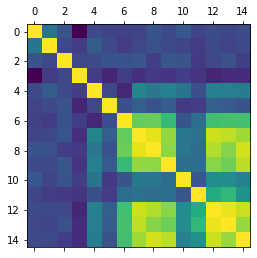

In [8]:
plt.matshow(df.corr())

In [9]:
df.corr()

,driver_id,owner_id,driver_age,completed_trips,vehicle_price,lead_time,trip_length,trip_revenue,young_driver_fee,insurance_fee,delivery_fee,other_revenue,gross_revenue,owner_earnings,net_revenue
driver_id,1.000000,0.242327,0.075014,-0.241300,0.033677,0.015671,0.002305,0.015334,0.081722,0.036670,0.098948,0.017673,0.040946,0.021917,0.042015
owner_id,0.242327,1.000000,0.034520,-0.026126,0.124963,0.033704,-0.024346,0.028744,0.068866,0.036765,0.018897,-0.026326,0.032115,0.008329,0.033536
driver_age,0.075014,0.034520,1.000000,0.026774,0.036864,0.078536,0.071485,0.092959,-0.012548,0.090991,0.075726,-0.029797,0.029334,0.064712,-0.011513
completed_trips,-0.241300,-0.026126,0.026774,1.000000,-0.016336,-0.110419,-0.013006,-0.074610,-0.030571,-0.049364,-0.011348,-0.051584,-0.111899,-0.086000,-0.080676
vehicle_price,0.033677,0.124963,0.036864,-0.016336,1.000000,0.029677,-0.107015,0.327840,0.250158,0.303356,0.241802,0.060054,0.306094,0.290682,0.280289
lead_time,0.015671,0.033704,0.078536,-0.110419,0.029677,1.000000,0.061148,0.134370,0.070615,0.112707,-0.028644,-0.016259,0.133739,0.113588,0.077511
trip_length,0.002305,-0.024346,0.071485,-0.013006,-0.107015,0.061148,1.000000,0.707289,0.723431,0.591510,0.078576,0.205498,0.625834,0.638286,0.629676
trip_revenue,0.015334,0.028744,0.092959,-0.074610,0.327840,0.134370,0.707289,1.000000,0.950658,0.798065,0.260584,0.225828,0.904101,0.880599,0.822180
young_driver_fee,0.081722,0.068866,-0.012548,-0.030571,0.250158,0.070615,0.723431,0.950658,1.000000,0.788569,0.248623,0.203875,0.857189,0.773417,0.920626
insurance_fee,0.036670,0.036765,0.090991,-0.049364,0.303356,0.112707,0.591510,0.798065,0.788569,1.000000,0.209396,0.204968,0.780447,0.724147,0.872440


It looks like the revenue features are highly correlated. Lets look at a pair plot of the data.

In [10]:
#sns.pairplot(df[numericColumns].fillna(0))

What are the variables most related to Net Revenue?

In [11]:
dfDummies = pd.get_dummies(df.drop(['make','model','driver_id','owner_id','payment_type'], axis=1), drop_first=True)

In [12]:
v = ['driver_age','completed_trips', 'vehicle_price', 'lead_time', 'trip_length', 'net_revenue', 'gross_revenue','insurance_fee','delivery_fee','other_revenue',
    'first_or_returning_guest_Repeat', 'first_or_returning_host_Repeat','trip_revenue']
dfDummies = dfDummies[dfDummies['driver_age']>25]
#scaler = preprocessing.StandardScaler()# Fit your data on the scaler object
dfNet=dfDummies[v].dropna()

In [13]:
X = dfNet.drop('net_revenue',axis=1)
y = dfNet['net_revenue']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.4)
model_xgb = xgboost.XGBRegressor(n_estimators=80, max_depth=5, learning_rate=.1, objective='reg:squarederror') #the params were tuned using xgb.cv
model_xgb.fit(Xtrain, ytrain)
model_xgb.score(Xtest, ytest)

/srv/conda/envs/notebook/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.9363115999270006

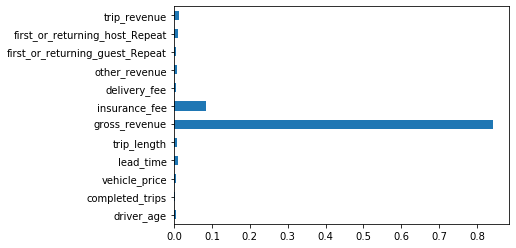

In [14]:
pd.Series(model_xgb.feature_importances_, index=Xtrain.columns).plot.barh()

What is gross revenue based on? It is probably a sum of all revenue columns

In [15]:
v = ['driver_age','completed_trips', 'vehicle_price', 'lead_time', 'trip_length', 'gross_revenue','insurance_fee','delivery_fee','other_revenue',
    'first_or_returning_guest_Repeat', 'first_or_returning_host_Repeat','trip_revenue']
dfDummies = dfDummies[dfDummies['driver_age']>25]
#scaler = preprocessing.StandardScaler()# Fit your data on the scaler object
dfGross=dfDummies[v].dropna()

In [16]:
X = dfGross.drop('gross_revenue',axis=1)
y = dfGross['gross_revenue']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.4)

In [17]:
alphas = [.01, .05, .1, .5, 1, 5, 10, 15, 20, 25, 30, 35, 40, 50, 100, 125, 150, 175, 200, 250, 300,400,500,600]
ridgeCV = []
for alpha in alphas:
    model = Ridge(alpha = alpha)
    rmse = np.sqrt(-cross_val_score(model, Xtrain, ytrain, scoring="neg_mean_squared_error", cv = 5)).mean()
    ridgeCV.append(rmse)
    
alphaSearch = pd.Series(ridgeCV, index=alphas)

Text(0, 0.5, 'rmse')

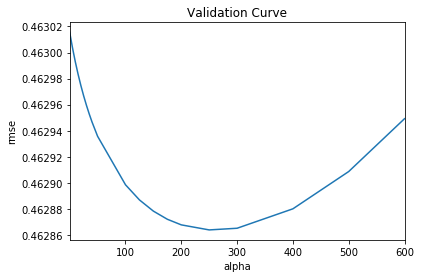

In [18]:
alphaSearch.plot(title = "Validation Curve")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [19]:
alphaSearch.sort_values().head()

250.0    0.462864
300.0    0.462865
200.0    0.462868
175.0    0.462872
150.0    0.462878
dtype: float64

In [20]:
ridgeModel = Ridge(alpha=175)
ridgeModel.fit(Xtrain, ytrain)

Ridge(alpha=175, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [21]:
ridgeModel.score(Xtest, ytest)

0.9999924305191369

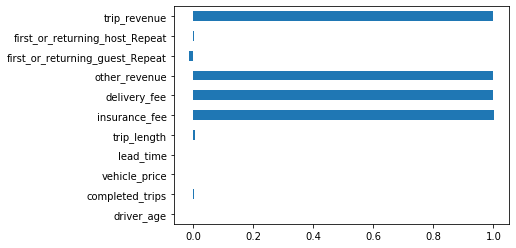

In [22]:
pd.Series(ridgeModel.coef_,index=Xtrain.columns).plot.barh()

It looks like repeat users have an ousized impact on gross revenue. Lets check with XGBoost feature importance.

In [23]:
model_xgb = xgboost.XGBRegressor(n_estimators=80, max_depth=5, learning_rate=.1, objective='reg:squarederror') #the params were tuned using xgb.cv
model_xgb.fit(Xtrain, ytrain)
model_xgb.score(Xtest, ytest)

/srv/conda/envs/notebook/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.9948293248713423

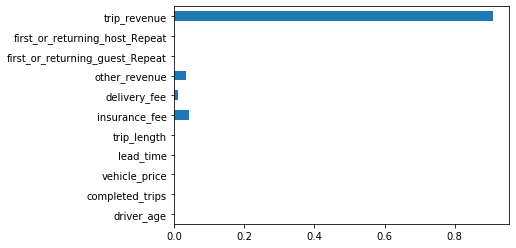

In [24]:
pd.Series(model_xgb.feature_importances_, index=Xtrain.columns).plot.barh()

Trip revenue makes up most of the gross revenue, although the other revenues and fees contribute.

What non-revenue variables is trip_revenue based on?

In [25]:
v = ['driver_age','completed_trips', 'vehicle_price', 'lead_time', 'trip_length','trip_revenue',
    'first_or_returning_guest_Repeat', 'first_or_returning_host_Repeat']
dfDummies = dfDummies[dfDummies['driver_age']>25]

dfLR=dfDummies[v].dropna()

In [26]:
X = dfLR.drop('trip_revenue',axis=1)
y=dfLR['trip_revenue']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.4)

In [27]:
alphas = [.01, .05, .1, .5, 1, 5, 10, 15, 20, 25, 30, 35, 40, 50, 100, 125, 150, 175, 200, 250, 300,400,500,600]
ridgeCV = []
for alpha in alphas:
    model = Ridge(alpha = alpha)
    rmse = np.sqrt(-cross_val_score(model, Xtrain, ytrain, scoring="neg_mean_squared_error", cv = 5)).mean()
    ridgeCV.append(rmse)
    
alphaSearch = pd.Series(ridgeCV, index=alphas)

Text(0, 0.5, 'rmse')

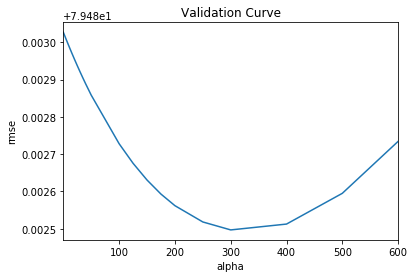

In [28]:
alphaSearch.plot(title = "Validation Curve")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [29]:
alphaSearch.sort_values().head()

300.0    79.482497
400.0    79.482512
250.0    79.482518
200.0    79.482562
175.0    79.482593
dtype: float64

In [30]:
ridgeModel = Ridge(alpha=500, normalize=False)
ridgeModel.fit(Xtrain, ytrain)

Ridge(alpha=500, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [31]:
ridgeModel.score(Xtest, ytest)

0.7017633455295564

In [32]:
pd.Series(ridgeModel.coef_,index=Xtrain.columns)

driver_age                          0.030191
completed_trips                    -0.447706
vehicle_price                       0.004714
lead_time                           0.284328
trip_length                        30.388304
first_or_returning_guest_Repeat    -7.181899
first_or_returning_host_Repeat      1.741058
dtype: float64

Lets double-check the results by looking at feature importance with XGBoost

In [33]:
model_xgb = xgboost.XGBRegressor(n_estimators=60, max_depth=2, learning_rate=.1, objective='reg:squarederror') #the params were tuned using xgb.cv
model_xgb.fit(Xtrain, ytrain)
model_xgb.score(Xtest, ytest)

/srv/conda/envs/notebook/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.8028749233646523

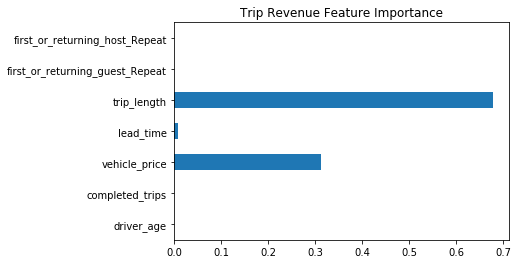

In [34]:
pd.Series(model_xgb.feature_importances_, index=Xtrain.columns).plot(kind='barh', title='Trip Revenue Feature Importance')

It looks like trip revenue is 66% trip length and 33% vehicle price. The other variables may be a percentage of trip revenue.

Possible ways to increase income by increasing trip length or increasing vehicle price?

Hypothesis: other_income is mainly tips

In [35]:
(df['other_revenue']/df['trip_revenue']).describe()

count    72729.000000
mean         0.287808
std          0.795692
min          0.000000
25%          0.100000
50%          0.105263
75%          0.194737
max         35.045456
dtype: float64

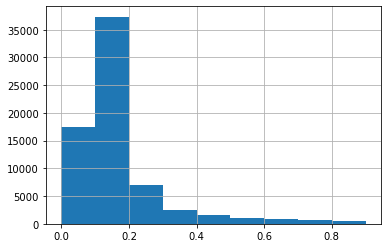

In [36]:
(df['other_revenue']/df['trip_revenue']).hist(bins=[i/10 for i in range(0,10)])

Most of the numbers are between 0 and 20% of trip income. This looks confirmed, although some of the values are surprisingly large.

Is there a relationship between age and income (other than withyoung driver fee)?

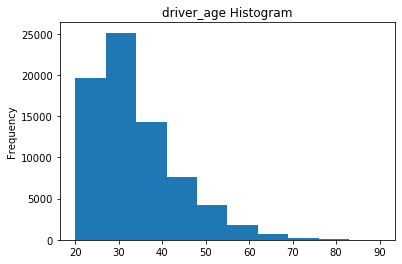

In [37]:
df['driver_age'].plot(kind='hist', title='driver_age Histogram')

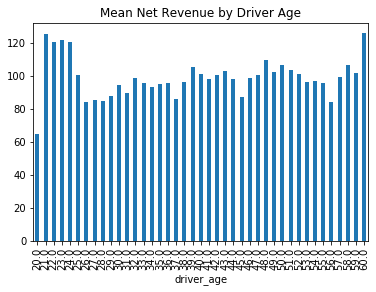

In [38]:
df.groupby('driver_age')['net_revenue'].mean()[20:60].plot(kind='bar', title='Mean Net Revenue by Driver Age')

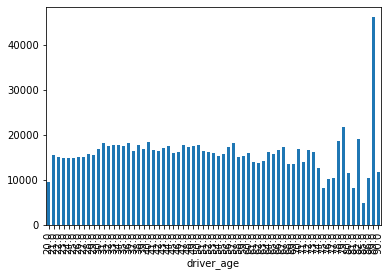

In [39]:
df.groupby('driver_age')['vehicle_price'].mean().plot.bar()

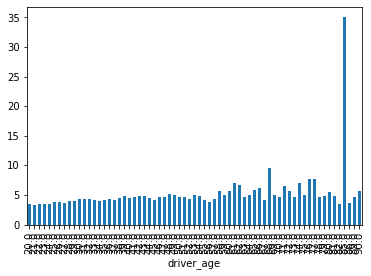

In [40]:
df.groupby('driver_age')['trip_length'].mean().plot.bar()

Young Driver Fee is increasing the revenue for youngest drivers, offsetting slightly lower vehicle price for those age groups